# Predicting FedEX Cup points on the PGA TOUR

We will analyze data and statistics from pgatour players to predict fedex cup points every year based on several statistics (driving distance, green in regulation percentage, strokes gained in each category, etc.) from the pgatour. Becaues I consider stats like money and scoring average to be other measures of success on their own, I will omit them from my features. This data will be extracted from the PGAtourwebsite using BeautifulSoup, and will be converted to a dataframe using pandas. A polynomial model will be used to predict points made by each player; r^2 and RMSE will be the measure of the accuracy of the model. In future iterations of this project, more work will be done on developing a better model.



# Extracting data from pgatour.com

### First cell:
import statements 
### Second cell:
A split function that allows for all the data for each feature to be arranged in the same way, allowing us to use iloc to access the data that we want (the name and main stat of interest from each page)
### Third cell:
a function that gets stats for each player during a certain year. The variable names correspond as follows: <br> 
    sgott: strokes gained off the tee <br>
    sgatg: strokes gained approaching the green <br>
    sgptg: strokes gained putting <br>
    sgarg: strokes gained around the green <br>
    ppr: putts per round
    drdist: driving distance <br>
    dracc: driving accuracy <br>
    greensacc: greens in regulation percentage <br>
    points: number of fedex cup points 
### Fourth cell: 
The code is a little "hacky", but I was able to efficiently get the stats I wanted to in relatively short amount of code. If I wanted to get more stats per page, most likely the code would have to be written in a different way


In [1409]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore")

In [1410]:
def split1(string):
    x = string.split()
    name, arr, count, index = "", [], 0, 0
    for i in x:
        try:
            float(i.replace('T', "").replace(",", ""))
            count += 1
        except ValueError:
            if index != 0:
                arr.append(i)
            name = name + ' ' + i
            index = count
    name = name.strip()
    x[index] = name
    for i in arr:
        x.remove(i)
    return x

In [1411]:
def get_urls(year):
    year = str(year)
    sgott = "https://www.pgatour.com/stats/stat.02567." + year + ".html"
    sgatg = "https://www.pgatour.com/stats/stat.02568." + year + ".html"
    sgptg = "https://www.pgatour.com/stats/stat.02564." + year + ".html"
    sgarg = "https://www.pgatour.com/stats/stat.02569." + year + ".html"
    ppr = "https://www.pgatour.com/stats/stat.119." + year + ".html"
    drdist = "https://www.pgatour.com/stats/stat.101." + year + ".html"
    dracc = "https://www.pgatour.com/stats/stat.102."  + year + ".html"
    greensacc = "https://www.pgatour.com/stats/stat.103." + year + ".html"
    points = "https://www.pgatour.com/stats/stat.02394." + year + ".html"
    urls = [sgott , sgatg, sgptg, sgarg, drdist, dracc, greensacc, ppr, points]
    urls_names = ['sgott', 'sgatg', 'sgptg', 'sgarg', 'drdist', 'dracc', 'greensacc', 'ppr', 'points']
    return urls, urls_names

In [1412]:
def constructdataframe_for_year(year):
    urls, urls_names = get_urls(year)
    pgaTourdf = pd.DataFrame()
    for i in range(len(urls)):
        page = requests.get(urls[i])
        soup = BeautifulSoup(page.content, "html.parser")
        rows = soup.findAll('tr')
        playerstats = []
        #first two rows is text
        for x in range(2, len(rows)):
            player = rows[x].getText().replace("\n", " ")
            playerstats.append(player)
        #split each stat
        statdf = (pd.Series(playerstats)).apply(split1).values.tolist()
        statdf = pd.DataFrame(statdf)
        #some pgatour stats have unnessesary 1 column that repeats the original 0 column. The len > 40 is beause of ties, which arent considered numeric
        if len(statdf[statdf[1].replace('T', "").str.isnumeric()]):
            statdf.drop(columns=[1], inplace=True)
        try:
            statdf[3] = statdf[3].astype(float)
        except: 
            statdf[3] = (statdf[3].str.replace(',', '')).astype(float)
        statdf = statdf.rename(columns={ statdf.columns[3]: urls_names[i], statdf.columns[1]: 'Name' })
        statdf = statdf.iloc[:, [1, 3]]
        if len(pgaTourdf) == 0:
            pgaTourdf = statdf
        else:
            pgaTourdf = pgaTourdf.merge(statdf, on='Name')
    pgaTourdf['year'] = str(year)
    return pgaTourdf

In [1237]:
def constructtraindf():
    traindf = pd.DataFrame()
    for i in range(2014, 2018):
        if i == 2014:
            traindf = constructdataframe_for_year(2014)
        else:
            traindf = traindf.append(constructdataframe_for_year(i))
    traindf.reset_index(drop=True, inplace=True)
    traindf.iloc[:, 1:-1] = traindf.iloc[:, 1:-1].astype(float)
    return traindf

In [1336]:
traindf = constructtraindf()
validatedf = constructdataframe_for_year(2018)

In [1239]:
traindf

,Name,sgott,sgatg,sgptg,sgarg,drdist,dracc,greensacc,ppr,points,year
0,Rory McIlroy,1.367,0.602,0.274,0.022,310.5,59.93,69.44,28.59,2582.0,2014
1,Bubba Watson,0.967,0.324,-0.050,0.111,314.3,60.47,67.96,28.99,2173.0,2014
2,Ryan Palmer,0.760,0.133,0.295,0.078,300.4,58.55,66.67,28.73,1068.0,2014
3,Boo Weekley,0.732,0.044,-1.152,0.099,288.3,69.57,68.06,30.56,496.0,2014
4,Dustin Johnson,0.730,0.533,0.082,-0.015,311.0,57.18,68.03,28.74,1769.0,2014
5,Adam Scott,0.725,0.610,0.220,0.166,303.5,61.51,68.79,28.76,1479.0,2014
6,Louis Oosthuizen,0.724,-0.145,-0.429,-0.367,300.5,60.90,66.43,29.98,453.0,2014
7,Hunter Mahan,0.687,-0.221,0.207,-0.153,295.8,65.10,66.67,29.33,776.0,2014
8,Henrik Stenson,0.650,0.575,-0.170,-0.064,293.2,68.78,69.03,29.89,720.0,2014
9,Jhonattan Vegas,0.628,-0.439,-0.370,0.125,304.8,61.16,69.11,30.13,505.0,2014


In [1312]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

# Analyzing correlation of features to FedEx Cup points

### Strokes gained off the tee vs points

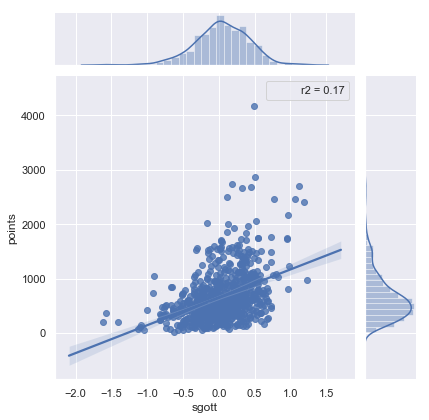

In [1308]:
sns.jointplot(stats_toviz['sgott'].astype(float), stats_toviz['points'], kind="reg",stat_func =r2)

### Strokes gained approach to the green vs points

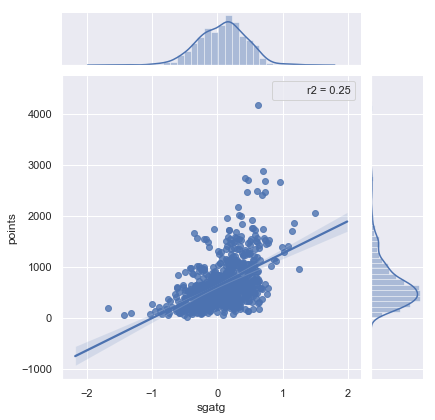

In [1314]:
sns.jointplot(stats_toviz['sgatg'].astype(float), stats_toviz['points'], kind="reg",stat_func =r2)

### Strokes gained around the green vs points

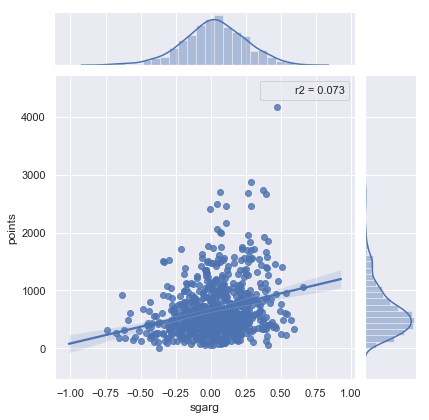

In [1315]:
sns.jointplot(stats_toviz['sgarg'].astype(float), stats_toviz['points'], kind="reg",stat_func =r2)

### Strokes gained putting vs points

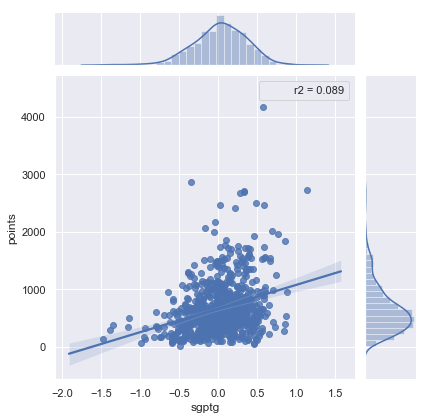

In [1325]:
sns.jointplot(stats_toviz['sgptg'].astype(float), stats_toviz['points'], kind="reg",stat_func =r2)

### Driving distance vs Points

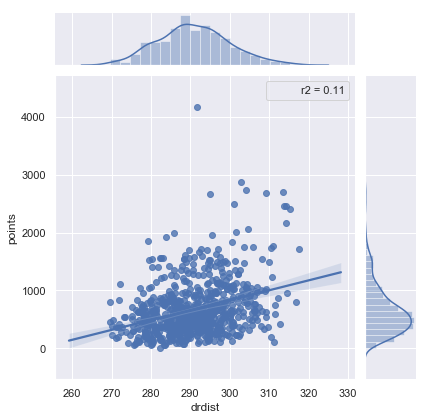

In [1328]:
sns.jointplot(stats_toviz['drdist'].astype(float), stats_toviz['points'], kind="reg",stat_func =r2)

### Putts Per Round vs Points

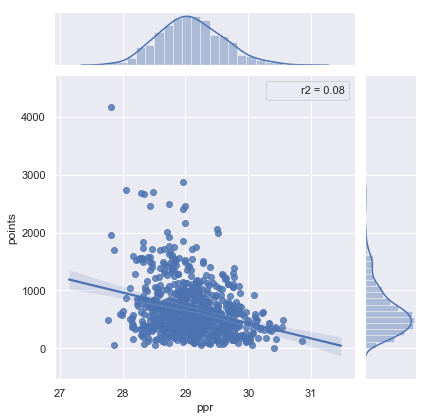

In [1299]:
sns.jointplot(stats_toviz['ppr'].astype(float), stats_toviz['points'], kind="reg",stat_func =r2)

### Driving accuracy vs points

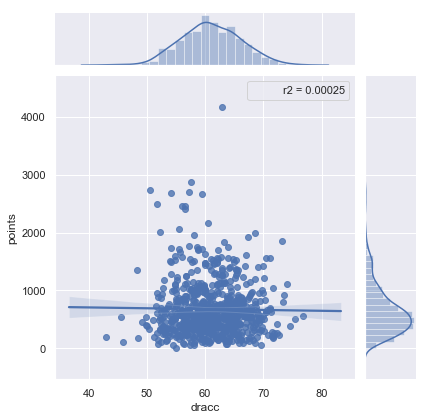

In [1319]:
sns.jointplot(stats_toviz['dracc'].astype(float), stats_toviz['points'], kind="reg",stat_func =r2)

### Greens in regulation percentage vs Points

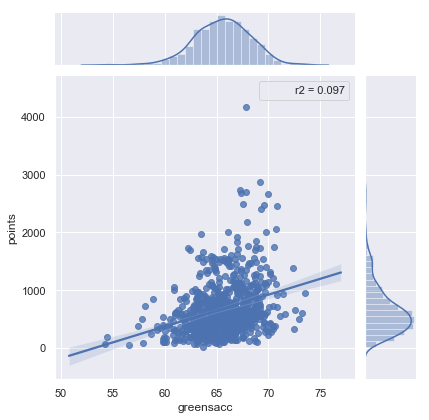

In [1330]:
sns.jointplot(stats_toviz['greensacc'].astype(float), stats_toviz['points'], kind="reg",stat_func =r2)

## Some interesting things to note

Analyzing the joint plot and r^2 values above for each feature it is apparent how important the long game and approaches to the green are;
strokes gained approaching the green had the highest correlation with fedex cup points. Strokes gained putting and putts per round both 
had less than a .10 r^2 value, which means putting doesn't have as high of an impact on the pgatour as one might think. These figures
confirm Mark Broadie's statment about long game being more important than short game and putting on the PGA Tour. Perhaps the most surprising correlation stat
was that of driving accuracy, which had almost no positive correlation with FedEx cup points.

In [1345]:
#Fitting a polynomial model to our data, and predicting on 2018 data

In [1406]:
from sklearn import svm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


x = traindf.drop(columns=['points', 'Name', 'year'])
y = traindf['points']
x_test = validatedf.drop(columns=['points', 'Name', 'year'])
poly = PolynomialFeatures(degree=2)
X_ = poly.fit_transform(x)
X_test_ = poly.fit_transform(x_test)
lg = LinearRegression()
lg.fit(X_, y)
x = lg.predict(X_test_)

In [1407]:
comparedf = validatedf[['Name', 'points']]
comparedf['points_predicted'] = x.round()
comparedf.loc[comparedf['points_predicted'] < 0, 'points_predicted'] = comparedf['points_predicted'].abs().min()
comparedf

,Name,points,points_predicted
0,Dustin Johnson,2717.0,2819.0
1,Jon Rahm,1430.0,1108.0
2,Gary Woodland,1044.0,746.0
3,Luke List,1080.0,1046.0
4,Bubba Watson,1879.0,826.0
5,Rory McIlroy,1154.0,1523.0
6,Keith Mitchell,659.0,414.0
7,Francesco Molinari,1682.0,1175.0
8,Brooks Koepka,2012.0,1434.0
9,Patrick Cantlay,1388.0,1108.0


In [1408]:
from sklearn.metrics import mean_squared_error

print(np.sqrt(mean_squared_error(validatedf['points'], comparedf['points_predicted'])))
print(r2(validatedf['points'], comparedf['points_predicted']))

275.50288300064426
0.6619047234269151


# Conclusions/Things to expand on :
    
Our r^2 value is .661 on our validation data so our model is ok, but not great. Our RMSE value is high because of the range of our output data. More work can go into scraping and choosing more features from the pgatour website. In addition, because this is a linear model, it wasn't surprising some of our outputs were negative; however since Fedex cup points can't be negative, a quick solution to this was to replace values negative values with the minimum positive value. However, this is an easy fix and more work would be needed in order to choosing a model where a fix like this isn't necesssary. In addition, with more features more work could be done into doing a more thourough EDA.